In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

In [3]:
%cd /content/ImageBind

/content/ImageBind


In [5]:
from torchvision import transforms
from PIL import Image
import torch

def load_and_transform_vision_data(image_paths, device):
    data_outputs = []
    data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

    for image_path in image_paths:
        with open(image_path, "rb") as fopen:
            image = Image.open(fopen).convert("RGB")
        image = data_transform(image).to(device)
        data_outputs.append(image)

    return torch.stack(data_outputs, dim=0)

image_paths = ["/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/ben480.jpg", "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/ben481.jpg",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/ben482.jpg", "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/ben51.jpg",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/ben52.jpg", "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/mal368.jpg",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/mal369.jpg", "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/mal370.jpg",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/mal371.jpg", "/content/drive/MyDrive/Data_Mining_CMPE_255/SkinCancer/mal372.jpg",]

device = "cuda:0" if torch.cuda.is_available() else "cpu"
vision_data = load_and_transform_vision_data(image_paths, device)

In [6]:
%cd /content/ImageBind

/content/ImageBind


In [10]:
from imagebind import data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Process the image data
inputs = {
    ModalityType.VISION: vision_data
}

with torch.no_grad():
    embeddings = model(inputs)

# embeddings now contain the image embeddings


100%|██████████| 4.47G/4.47G [01:09<00:00, 69.3MB/s]


In [12]:
print(embeddings)

{'vision': tensor([[-0.0206,  0.0223, -0.0011,  ..., -0.0073, -0.0217, -0.0257],
        [-0.0285,  0.0163, -0.0051,  ..., -0.0174, -0.0200, -0.0209],
        [-0.0325,  0.0218, -0.0090,  ..., -0.0106, -0.0261, -0.0252],
        ...,
        [-0.0220,  0.0241, -0.0017,  ..., -0.0086, -0.0233, -0.0254],
        [-0.0222,  0.0201, -0.0052,  ..., -0.0160, -0.0210, -0.0237],
        [-0.0215,  0.0203, -0.0009,  ..., -0.0067, -0.0154, -0.0282]],
       device='cuda:0')}


In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Extract the tensor from the dictionary
embeddings_tensor = embeddings['vision']

# Move the tensor to CPU and convert to NumPy array
embeddings_2d = embeddings_tensor.cpu().numpy()

# Define the number of clusters
num_clusters = 2  # Adjust based on your requirements

# Initialize and fit the k-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_2d)

# 'clusters' now contains the cluster assignment for each image

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


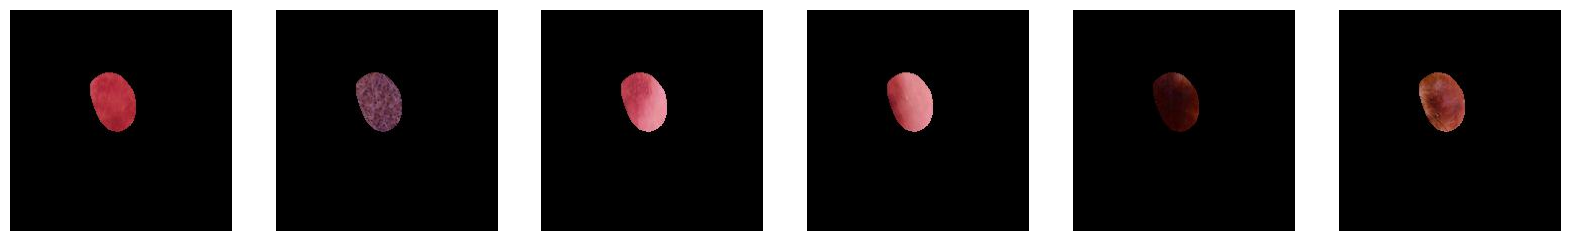

In [17]:
import matplotlib.pyplot as plt

def show_images_from_cluster(cluster_id, num_images, image_paths, clusters):
    """
    Displays images from the specified cluster.

    Args:
    cluster_id (int): The cluster ID to display images from.
    num_images (int): Number of images to display.
    image_paths (list): List of paths to the images.
    clusters (np.array): Array of cluster assignments for each image.
    """
    # Find indices of images in the specified cluster
    indices = [i for i, cluster in enumerate(clusters) if cluster == cluster_id]

    # If there are fewer images in the cluster than requested, adjust the number of images
    num_images = min(num_images, len(indices))

    # Plotting
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20), squeeze=False)
    for i, idx in enumerate(indices[:num_images]):
        image = plt.imread(image_paths[idx])
        axs[0, i].imshow(image)
        axs[0, i].axis('off')
    plt.show()


#Showing images from cluster 0
show_images_from_cluster(0, 10, image_paths, clusters)

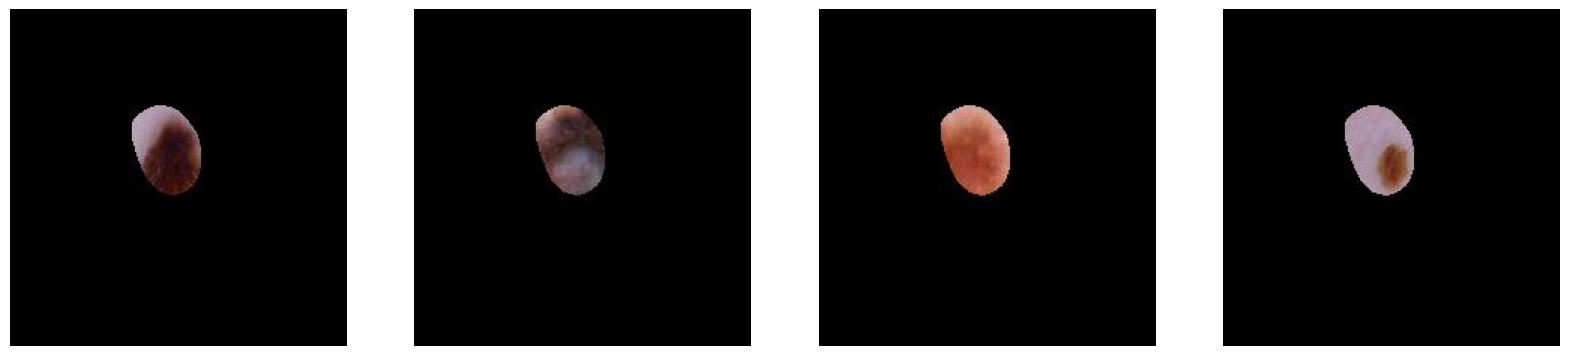

In [18]:
#Showing images from cluster 1
show_images_from_cluster(1, 10, image_paths, clusters)